In [1]:
!pip install pandas numpy scikit-learn xgboost shap country_converter matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 1.9 MB/s eta 0:00:00


In [2]:
# file: model_subsidy_pm25.py
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import os

In [3]:
from google.colab import files
uploaded = files.upload()

Saving data_polusi_pm2.5.csv to data_polusi_pm2.5.csv
Saving data_subsidi_fossil_fuel.xlsx to data_subsidi_fossil_fuel.xlsx


In [16]:
# ---- utils ----
def wide_to_long_years(df, id_vars=None, value_name="value"):
    """
    Convert table with year columns like '2010'..'2020' into long format.
    id_vars: list of id columns to keep. If None, pandas will infer non-year columns.
    """
    # detect year-like columns
    year_cols = [c for c in df.columns if isinstance(c, str) and c.strip()[:4].isdigit()]
    if id_vars is None:
        id_vars = [c for c in df.columns if c not in year_cols]
    long = df.melt(id_vars=id_vars, value_vars=year_cols, var_name="YearRaw", value_name=value_name)
    long["Year"] = long["YearRaw"].str.extract(r'(\d{4})').astype(float).astype('Int64')
    long = long.drop(columns=["YearRaw"])
    return long

In [28]:
# ---- load CSV (World Bank style metadata) ----
csv_path = "./data_polusi_pm2.5.csv"

# Load the data correctly - DON'T skip the header row
meta = pd.read_csv(csv_path, encoding="ISO-8859-1", on_bad_lines="skip", delimiter=',')

print("Column names after loading:")
print(meta.columns.tolist())
print(f"\nShape: {meta.shape}")

print("\nFirst few rows:")
print(meta.head(3))

Column names after loading:
['Country Name', 'Country Code', 'Series Name', 'Series Code', '2010 [YR2010]', '2011 [YR2011]', '2012 [YR2012]', '2013 [YR2013]', '2014 [YR2014]', '2015 [YR2015]', '2016 [YR2016]', '2017 [YR2017]', '2018 [YR2018]', '2019 [YR2019]', '2020 [YR2020]']

Shape: (223, 15)

First few rows:
  Country Name Country Code  \
0  Afghanistan          AFG   
1      Albania          ALB   
2      Algeria          DZA   

                                         Series Name        Series Code  \
0  PM2.5 air pollution, mean annual exposure (mic...  EN.ATM.PM25.MC.M3   
1  PM2.5 air pollution, mean annual exposure (mic...  EN.ATM.PM25.MC.M3   
2  PM2.5 air pollution, mean annual exposure (mic...  EN.ATM.PM25.MC.M3   

      2010 [YR2010]     2011 [YR2011]     2012 [YR2012]     2013 [YR2013]  \
0  49.6793770289443  61.8170559083924  70.9223165078033  73.1318159038053   
1  20.8141104654758  22.7999042481871  20.9627204112539  19.4075322522058   
2  24.3952993862667  23.572107

In [29]:
# Method 1: Try different delimiters and encodings
print("=== Testing different delimiters ===")
for delimiter in [',', ';', '\t', '|']:
    try:
        print(f"\nTrying delimiter: '{delimiter}'")
        df_test = pd.read_csv(csv_path, delimiter=delimiter, encoding="ISO-8859-1", nrows=2)
        print(f"Number of columns: {len(df_test.columns)}")
        print(f"Column names: {list(df_test.columns[:5])}")  # Show first 5 columns
        if len(df_test.columns) > 1:
            print("✓ This delimiter works!")
            break
    except Exception as e:
        print(f"Error with delimiter '{delimiter}': {e}")

=== Testing different delimiters ===

Trying delimiter: ','
Number of columns: 15
Column names: ['Country Name', 'Country Code', 'Series Name', 'Series Code', '2010 [YR2010]']
✓ This delimiter works!


In [30]:
# Now this should work:
# filter PM2.5 series rows
pm25_df = meta[meta["Series Name"].str.contains("PM2.5", case=False, na=False)].copy()
pm25_long = wide_to_long_years(pm25_df, id_vars=["Country Name","Country Code","Series Name","Series Code"], value_name="PM25_value")
pm25_long = pm25_long.rename(columns={"Country Name":"Country","Country Code":"CountryCode"})
pm25_long["PM25_value"] = pd.to_numeric(pm25_long["PM25_value"], errors="coerce")
pm25_long = pm25_long.dropna(subset=["PM25_value"])
pm25_long["Country_lc"] = pm25_long["Country"].str.lower().str.replace(r'\s+',' ', regex=True).str.strip()

print("PM2.5 data shape:", pm25_long.shape)
print("Sample data:")
print(pm25_long.head())

PM2.5 data shape: (2200, 7)
Sample data:
          Country CountryCode  \
0     Afghanistan         AFG   
1         Albania         ALB   
2         Algeria         DZA   
3  American Samoa         ASM   
4         Andorra         AND   

                                         Series Name        Series Code  \
0  PM2.5 air pollution, mean annual exposure (mic...  EN.ATM.PM25.MC.M3   
1  PM2.5 air pollution, mean annual exposure (mic...  EN.ATM.PM25.MC.M3   
2  PM2.5 air pollution, mean annual exposure (mic...  EN.ATM.PM25.MC.M3   
3  PM2.5 air pollution, mean annual exposure (mic...  EN.ATM.PM25.MC.M3   
4  PM2.5 air pollution, mean annual exposure (mic...  EN.ATM.PM25.MC.M3   

   PM25_value  Year      Country_lc  
0   49.679377  2010     afghanistan  
1   20.814110  2010         albania  
2   24.395299  2010         algeria  
3    6.124787  2010  american samoa  
4   12.375136  2010         andorra  


In [31]:
# ---- load Excel (subsidi data) ----
excel_path = "./data_subsidi_fossil_fuel.xlsx"
xls = pd.ExcelFile(excel_path)
# most likely sheet 'Table format'
df_table = pd.read_excel(xls, sheet_name='Table format', dtype=str)
# find subsidy-related rows
mask = df_table['SeriesDescription'].str.contains('subsid|fossil|fuel', case=False, na=False)
subs_rows = df_table[mask].copy()
# convert to long form
subs_long = wide_to_long_years(subs_rows, id_vars=['GeoAreaName','GeoAreaCode','SeriesDescription','Units'], value_name="Subsidy_value")
subs_long = subs_long.rename(columns={'GeoAreaName':'Country','GeoAreaCode':'CountryCode','SeriesDescription':'Series'})
subs_long["Subsidy_value"] = pd.to_numeric(subs_long["Subsidy_value"], errors="coerce")
subs_long = subs_long.dropna(subset=["Subsidy_value"])
subs_long["Country_lc"] = subs_long["Country"].str.lower().str.replace(r'\s+',' ', regex=True).str.strip()

In [33]:
# ---- country code normalization (optional but recommended) ----
# If subs_long CountryCode is M49 numeric and pm25 CountryCode is ISO3, map M49->ISO3 using country_converter
# country_converter accepts many inputs; we'll try to convert subs_long.Country (names) to ISO3 for robust merge
import country_converter as coco
conv = coco.CountryConverter()
subs_long["ISO3_from_name"] = conv.convert(names=subs_long["Country"].values, to='ISO3')
pm25_long["ISO3_from_name"] = conv.convert(names=pm25_long["Country"].values, to='ISO3')

In [34]:
# Prefer exact ISO3 if available in either side
subs_long['merge_key'] = subs_long["ISO3_from_name"].where(subs_long["ISO3_from_name"]!="not found", subs_long["Country_lc"])
pm25_long['merge_key'] = pm25_long["ISO3_from_name"].where(pm25_long["ISO3_from_name"]!="not found", pm25_long["Country_lc"])


In [35]:
# ---- merge ----
# Ensure merge_key is hashable (convert lists to strings)
subs_long['merge_key'] = subs_long['merge_key'].apply(lambda x: str(x) if isinstance(x, list) else x)
pm25_long['merge_key'] = pm25_long['merge_key'].apply(lambda x: str(x) if isinstance(x, list) else x)

merged = pd.merge(subs_long, pm25_long, left_on=['merge_key','Year'], right_on=['merge_key','Year'], how='inner', suffixes=('_sub','_pm25'))
if merged.empty:
    # fallback: merge on lowercased country name + year
    merged = pd.merge(subs_long, pm25_long, left_on=['Country_lc','Year'], right_on=['Country_lc','Year'], how='inner', suffixes=('_sub','_pm25'))

#print("Merged rows:", len(merged))
# show sample
print(merged[['Country_sub','CountryCode_sub','Year','Subsidy_value','PM25_value']].head(8))

print(merged)

   Country_sub CountryCode_sub  Year  Subsidy_value  PM25_value
0  Afghanistan               4  2010        0.03420   49.679377
1      Algeria              12  2010       13.38627   24.395299
2       Angola              24  2010        1.12664   24.178057
3    Argentina              32  2010        9.54424   13.927983
4      Armenia              51  2010        0.02819   34.447017
5    Australia              36  2010        7.80363    7.445152
6      Austria              40  2010        1.08947   15.986590
7   Azerbaijan              31  2010        1.08841   23.120176
                             Country_sub CountryCode_sub  \
0                            Afghanistan               4   
1                                Algeria              12   
2                                 Angola              24   
3                              Argentina              32   
4                                Armenia              51   
...                                  ...             ...   
1437

In [36]:
# Save the merged DataFrame to a CSV file
merged.to_csv("merged_subsidy_pm25.csv", index=False)
print("Merged data saved to merged_subsidy_pm25.csv")

Merged data saved to merged_subsidy_pm25.csv


In [37]:
# ---- feature engineering ----
df = merged.copy()
df['Subsidy_value'] = pd.to_numeric(df['Subsidy_value'], errors='coerce')
df = df.dropna(subset=['Subsidy_value','PM25_value'])
# create log feature (handles zero/neg by sign)
df['Log_Sub'] = np.log1p(df['Subsidy_value'].abs()) * np.sign(df['Subsidy_value'])
# optionally add lag features if you want time-dependence
df = df.sort_values(['merge_key','Year'])


In [38]:
# ---- modeling: XGBoost regression (predict PM2.5) ----
features = ['Subsidy_value','Log_Sub','Year']
X = df[features].values
y = df['PM25_value'].values

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [40]:
from xgboost import XGBRegressor

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=4, random_state=42, verbosity=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [41]:
# @title
# ---- evaluation ----
rmse = mean_squared_error(y_test, y_pred)#, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("RMSE:", rmse, "MAE:", mae, "R2:", r2)

RMSE: 305.35470812005065 MAE: 13.54307579150595 R2: 0.0038665013859897623


In [42]:
# @title
# ---- feature importance ----
if hasattr(model, "feature_importances_"):
    fi = model.feature_importances_
    for f, imp in sorted(zip(features, fi), key=lambda x: x[1], reverse=True):
        print(f, round(imp,4))

Subsidy_value 0.5889
Year 0.4111
Log_Sub 0.0


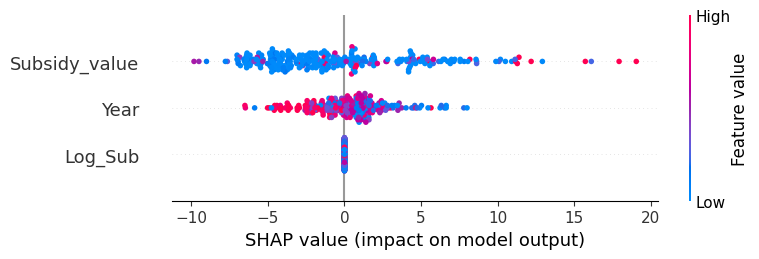

In [43]:
# @title
# ---- SHAP explainability (optional but recommended) ----
try:
    import shap
    explainer = shap.Explainer(model)
    shap_values = explainer(X_test)
    # summary plot (requires display)
    shap.summary_plot(shap_values, X_test, feature_names=features, show=True)
except Exception as e:
    print("SHAP not available or error:", e)

In [44]:
# @title
# ---- save model and sample predictions ----
import joblib
joblib.dump(model, "model_subsidy_pm25.joblib")
df_out = df[['Country_sub','Year','Subsidy_value','PM25_value']].copy()
df_out['Predicted_PM25'] = np.nan
# Put predictions for test rows back (this code assumes you kept indexes aligned; adapt if needed)
print("Saved model to model_subsidy_pm25.joblib. Sample rows saved to sample_predictions.csv")
df_out.head(10).to_csv("sample_predictions.csv", index=False)


Saved model to model_subsidy_pm25.joblib. Sample rows saved to sample_predictions.csv


## Prediction for Future Years
Now, let's use the trained model to predict PM2.5 values for future years. We'll need to create a DataFrame with future years and estimate or assume subsidy values for those years. For simplicity, we'll assume the subsidy value remains constant at the average value from the training data for each country, but in a real scenario, you would need a method to project future subsidy values.

In [45]:
# Create a DataFrame for future years (e.g., 2021-2025)
future_years = pd.DataFrame({
    'Year': range(2021, 2026),
})

# To make predictions for future years, we need corresponding subsidy values.
# For demonstration purposes, let's use the average subsidy value per country from the existing data.
# In a real application, you would need a method to forecast future subsidy values.
avg_subsidy_per_country = df.groupby('Country_sub')['Subsidy_value'].mean().reset_index()

# Create a DataFrame with all countries and future years
from itertools import product
future_data = pd.DataFrame(list(product(avg_subsidy_per_country['Country_sub'], future_years['Year'])), columns=['Country_sub', 'Year'])

# Merge with average subsidy values
future_data = pd.merge(future_data, avg_subsidy_per_country, on='Country_sub', how='left')

# Add the Log_Sub feature for future data
future_data['Log_Sub'] = np.log1p(future_data['Subsidy_value'].abs()) * np.sign(future_data['Subsidy_value'])

# Prepare features for prediction
X_future = future_data[features].values

# Make predictions
future_data['Predicted_PM25'] = model.predict(X_future)

# Display the predictions
print("\nPredictions for Future Years:")
display(future_data.head())


Predictions for Future Years:


,Country_sub,Year,Subsidy_value,Log_Sub,Predicted_PM25
0,Afghanistan,2021,0.016469,0.016335,24.896614
1,Afghanistan,2022,0.016469,0.016335,24.896614
2,Afghanistan,2023,0.016469,0.016335,24.896614
3,Afghanistan,2024,0.016469,0.016335,24.896614
4,Afghanistan,2025,0.016469,0.016335,24.896614
